# Visualizing Diffusion

## Introduction

One of the key ideas of diffusion models is the forward diffusion process involved.
By adding Gaussian noise to an input over a series of timesteps,
we're able to move the initial image to a latent space that approaches a Gaussian distribution.

In this notebook, we'll be seeing the effects of different choices of variance schedules.
The variance schedule will determine the variances of the noise we're adding to the image over time.
What happens when we choose the variance to be higher? What about lower?

We'll be exploring the effects of these choices by visualizing the state over the diffusion process,
and hopefully get a sense for how they relate to the rate at which this movement from
the original image / distribution to the latent Gaussian distribution occurs.

## Library imports

Before you begin, you'll need to set up your environment.

### If you're running locally:

To set up a new environment that contains the necessary libraries,
you can run the startup script by running `bash startup.sh`.

Double check that you are now in the `env-proj` conda environment that was created.
If not, run `conda activate env-proj` in your terminal.

### If you're running on Colab

Please change the following cell from `%matplotlib widget` to `%matplotlib inline`.
since Colab does not currently seem to support `ipympl` or `widget` out of the box.
(It may be able to support the `widget` mode but more setup for that may be required.)

### Double check

Make sure that the following libraries have been installed.

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from typing import List

In [2]:
import jax.numpy as jnp
from jax import jit, random, Array
from jax.config import config
config.update("jax_debug_nans", True)
config.update("jax_array", True)

## Part A: Mean and Covariance of Diffusion

Implement the forward diffusion process according to the formulas specified in problem (1) of the homework, specifically the mean and covariance of the forward process posterior Normal distribution. 
Run the cells immediately following to test your implementation.

**Note:**
If you run into issues or errors that mention `jit`,
feel free to comment out the `@jit` decorator at the top of the functions.
The `@jit` decorator is not needed for correctness, but may help speed up the code.

In [3]:
def compute_mean(x: Array, var: Array) -> Array:
    # BEGIN SOLUTION
    mean = jnp.dot(jnp.sqrt(1 - var), x)
    # END SOLUTION
    return mean

def compute_cov(x: Array, var: Array) -> Array:
    n = x.shape[0]
    # BEGIN SOLUTION
    cov = jnp.dot(var, jnp.eye(n))
    # END SOLUTION
    return cov

### Test your implementation

The following cells will test your implementation of the mean and covariance functions.
While there may be slight differences due to floating point accuracy,
your implementation should fall within the allowed error range.

In [4]:
from test_cases import run_diffusion_mean_tests, run_diffusion_cov_tests
run_diffusion_mean_tests(compute_mean)
run_diffusion_cov_tests(compute_cov)

Diffusion mean: Average difference between expected and actual: 7.450580152834618e-10
Diffusion mean: Result vs threshold: 7.450580152834618e-10 < 1e-05
Diffusion mean test passed! :)

Diffusion covariance: Average difference between expected and actual: 0.0
Diffusion covariance: Result vs threshold: 0.0 < 1e-05
Diffusion covariance test passed! :)



## Visualizing states over time

Now that we've verified the correctness of the calculated mean and covariance,
let's visualize how the states get diffused over time.

First, we'll want to set up the diffusion process by sampling from the multivariate
Gaussian normal that is characterized by our mean and covariance functions,
where we call `diffuse` to diffuse the state over a single timestep.
We will then want to repeat this over the length of the variance schedule,
as seen in `diffuse_over_time`.

In [5]:
@jit
def diffuse(key, x: Array, var: Array) -> Array:
    """
    Given (flattened) x, sample x diffused with Gaussian noise
    according to the variance schedule.
    """
    mean = compute_mean(x, var)
    cov = compute_cov(x, var)
    return random.multivariate_normal(key, mean, cov)

@jit
def diffuse_over_time(key, x: Array, var_schedule: Array) -> List[Array]:
    states = [x]
    shape = x.shape
    x = x.flatten()
    for t in jnp.arange(var_schedule.shape[0]):
        key, subkey = random.split(key)
        x = diffuse(subkey, x, var_schedule[t])
        states.append(x.reshape(shape))
    return states


With these functions defined, we can now visualize how the identity matrix gets diffused over time,
according to each variance schedule.

In [6]:
from utils import show_plots

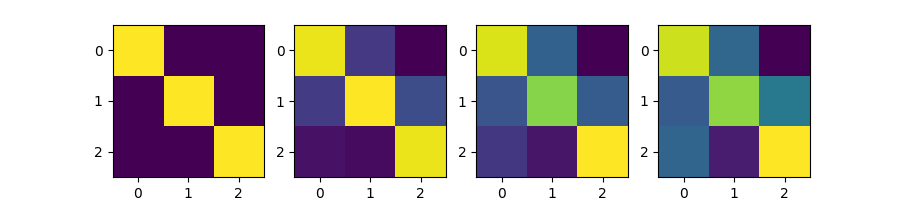

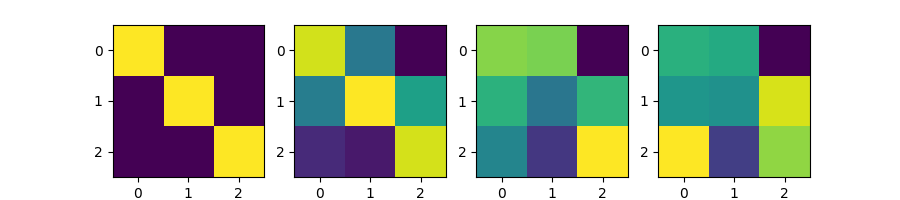

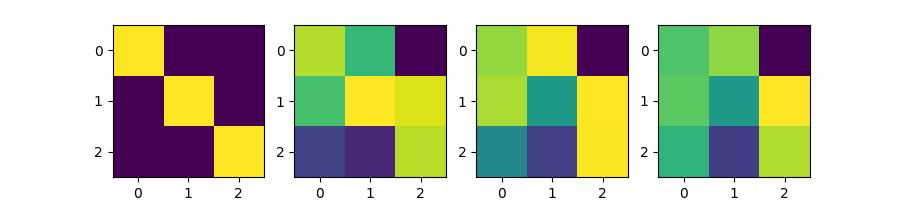

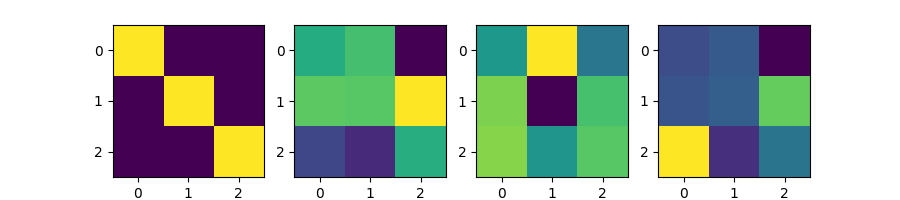

In [7]:
x = jnp.eye(3)

var_schedules = [
    jnp.array([0.01, 0.01, 0.01]),
    jnp.array([0.1, 0.2, 0.5]),
    jnp.array([0.5, 0.2, 0.1]),
    jnp.array([0.99, 0.99, 0.99]),
]

key = random.PRNGKey(0)
for var_schedule in var_schedules:
    states = diffuse_over_time(key, x, var_schedule)
    show_plots(states)

Now, can you come up with an interesting input `x` and one or more interesting variance schedules?
**Define your input and add variance schedules below.**

You can then run the cell to visualize your input being diffused
according to the variance schedules you proposed.

What kind of observations do you have?
What happens when you make the variances very high?
How about very low?
What if you alternate?
Can you still see traces of the original input's patterns in the final diffused state?
What about in the intermediate diffused states?

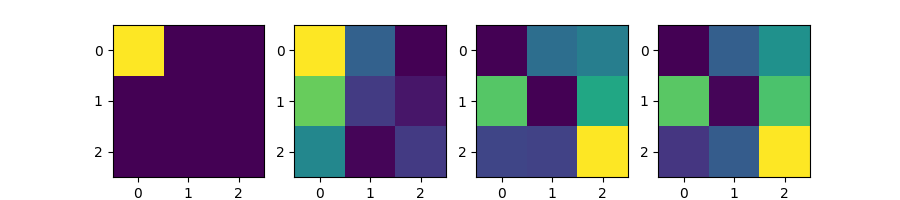

In [8]:
# BEGIN SOLUTION
x = jnp.array([
    [1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0]])
# END SOLUTION

var_schedules = [
    # BEGIN SOLUTION
    jnp.array([0.1, 0.99, 0.1])
    # END SOLUTION
]

key = random.PRNGKey(1)
for var_schedule in var_schedules:
    states = diffuse_over_time(key, x, var_schedule)
    show_plots(states)

## (Optional) Comparing the JIT and non-JIT versions of the diffusion process

You may have noticed the `@jit` decorator above the `diffuse` function earlier in this notebook.
`jax` provides `jit` as a way to speed up user-defined functions.
Here, we'll be comparing the performance of `diffuse` and its non-JIT version `diffuse_nojit`.

Run the following cell to see the difference in speed between `diffuse`
(that has been sped up by `jit`) and `diffuse_nojit` which has not had that speedup.

In [9]:
# An interesting comparison in timing between
# non-JIT and JIT versions of the diffuse function

def diffuse_nojit(key, x, var):
    """
    Given (flattened) x, sample x diffused with Gaussian noise
    according to the variance schedule.
    """
    # BEGIN SOLUTION
    mean = jnp.dot(jnp.sqrt(1 - var), x)
    cov = jnp.dot(var, jnp.eye(x.shape[0]))
    return random.multivariate_normal(key, mean, cov)
    # END SOLUTION

key = random.PRNGKey(0)
x = jnp.eye(3).flatten()

print("Timing for JIT diffuse:")
%timeit diffuse(key, x, 0.01)

print("Timing for non-JIT diffuse:")
%timeit diffuse_nojit(key, x, 0.01)

Timing for JIT diffuse:
78.5 µs ± 2.96 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Timing for non-JIT diffuse:
542 µs ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
